## Example 3.2 : Stochastic Approximation Cross-Entropy (SACE) algorithm

In [2]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

In [35]:
a = np.array([1,2,3,1,2])

paths = np.array([[0,3],[0,2,4],[1,2,3],[1,4]])

def nu_star(u):
    """Return the value of nu that minimizes the Kullback-Leibler divergence 
    of gν from the optimal importance distribution"""
    return(-1 / np.log(u))

def gibbs_sampler(Y,theta):
    n = np.size(Y)
    Ytilde = np.copy(Y)
    for i in range(n):
        Ytilde[i] = 0
        Y[i] = np.random.uniform(np.max([0,(theta-phi(Ytilde))]),1)
        Ytilde[i] = Y[i]
    return(Y)

def phi(U):
    minimum = 10000
    cost = 0
    for C in paths:
        cost = np.sum(a[C] * U[C])
        if cost < minimum:
            minimum = cost
    return(minimum)

def p(U):
    res = 1
    for u in U:
        if u<0 or u>1:
            res = 0
    return(res)  
    
def sufficient_stat(Y):
    return np.log(Y)    

def beta_product(Z,nu,b=1):
    n = np.size(Z)
    res = 1
    for i in range(n):
        res *= beta.pdf(Z[i],nu[i],b)
        if (Z[i]<0 or Z[i]>1):
            res = 0
    return(res)

def SACE(quantile):
    n = 5
    sigma = np.random.rand(5)
    nu = nu_star(sigma)
    Y = np.random.rand(5)
    theta = phi(Y)
    list_theta = []
    list_nu = []
    T = 50000
    for t in range(T):
        gamma = 0.001 / (t+1)
        Y = gibbs_sampler(Y,theta)
        Z = np.random.beta(nu,1,n)
        if phi(Z) <= theta:
            theta += gamma * (quantile - p(Z)/beta_product(Z,nu,1))
        else:
            theta += gamma * quantile
        sigma = (1-gamma) * sigma + gamma * sufficient_stat(Y)
        nu = nu_star(sigma)
        list_theta.append(theta)
        list_nu.append(nu)
        
    return(list_theta,list_nu)

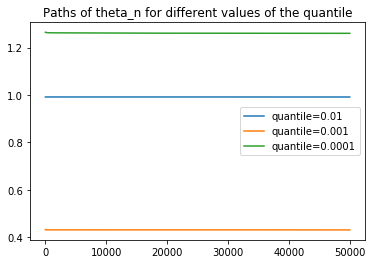

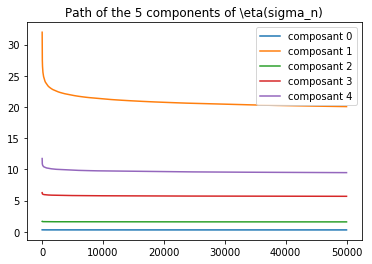

In [37]:
quantiles = [10e-3,10e-4,10e-5]
ls_theta = [[] for i in range(3)]
ls_nu = [[] for i in range(3)]
k = 0
for quantile in quantiles:
    ls_theta[k],ls_nu[k] = SACE(quantile)
    k += 1

plt.figure(1)
for k in range(3):
    plt.plot(ls_theta[k],label='quantile='+str(quantiles[k]))
plt.legend()
plt.title('Paths of theta_n for different values of the quantile')
plt.show()

ls_nu = np.array(ls_nu)
plt.figure(2)
for k in range(5):
    plt.plot(ls_nu[0,:,k],label='composant '+str(k))
plt.legend()
plt.title('Path of the 5 components of \eta(sigma_n)')
plt.show()

In [18]:
ls_theta[0][4000]

1.339112863500074